<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
</center>
Автор материала: аналитик-разработчик в команде Яндекс.Метрики Мария Мансурова. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center> Домашнее задание № 9
## <center> Анализ временных рядов

In [1]:
import pandas as pd
import os

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
import requests
import pandas as pd

print(__version__) # need 1.9.0 or greater

init_notebook_mode(connected = True)




def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

2.0.5


## Подготавливаем данные

Для начала скачаем данные в `dataframe`. Сегодня будем предсказывать просмотры wiki-страницы [Machine Learning](https://en.wikipedia.org/wiki/Machine_learning). Данные я скачала с помощью библиотеки [Wikipediatrend](https://www.r-bloggers.com/using-wikipediatrend/) для `R`.

In [2]:
df = pd.read_csv('../../data/wiki_machine_learning.csv', sep = ' ')
df = df[df['count'] != 0]
df.head()

,date,count,lang,page,rank,month,title
81,2015-01-01,1414,en,Machine_learning,8708,201501,Machine_learning
80,2015-01-02,1920,en,Machine_learning,8708,201501,Machine_learning
79,2015-01-03,1338,en,Machine_learning,8708,201501,Machine_learning
78,2015-01-04,1404,en,Machine_learning,8708,201501,Machine_learning
77,2015-01-05,2264,en,Machine_learning,8708,201501,Machine_learning


In [4]:
df.shape

(383, 7)

In [5]:
df.date = pd.to_datetime(df.date)

In [6]:
plotly_df(df.set_index('date')[['count']])

## Предсказание с помощью Facebook Prophet

Для начала построим предсказание с помощью простой библиотеки `Facebook Prophet`. Для того, чтобы посмотреть на качество модели, отбросим из обучающей выборки последние 30 дней.

In [7]:
from fbprophet import Prophet

In [8]:
predictions = 30

df = df[['date', 'count']]
df.columns = ['ds', 'y']
train_df = df[:-predictions].copy()

In [14]:
## ВАШ КОД для построения модели ##
prophet = Prophet(yearly_seasonality=True)
prophet.fit(train_df)

**Вопрос 1:** Какое предсказание числа просмотров wiki-страницы на 20 января? Ответ округлите до целого числа.

Оценим качество предсказания по последним 30 точкам.

In [15]:
future = prophet.make_future_dataframe(periods=30)
future.tail()

,ds
378,2016-01-16
379,2016-01-17
380,2016-01-18
381,2016-01-19
382,2016-01-20


In [16]:
forecast = prophet.predict(future)
forecast.tail()

,ds,t,trend,seasonal_lower,seasonal_upper,trend_lower,trend_upper,yhat_lower,yhat_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,seasonal,yhat
378,2016-01-16,1.073446,2946.748331,-461.131891,-461.131891,2946.748231,2946.748425,2129.396378,2830.932553,-860.441386,-860.441386,-860.441386,399.309494,399.309494,399.309494,-461.131891,2485.616440
379,2016-01-17,1.076271,2949.752360,-303.591130,-303.591130,2949.752253,2949.752459,2270.651514,3019.399793,-720.143785,-720.143785,-720.143785,416.552654,416.552654,416.552654,-303.591130,2646.161230
380,2016-01-18,1.079096,2952.756388,713.816039,713.816039,2952.756272,2952.756495,3282.533019,4030.035595,282.577995,282.577995,282.577995,431.238044,431.238044,431.238044,713.816039,3666.572427
381,2016-01-19,1.081921,2955.760417,981.307220,981.307220,2955.760295,2955.760530,3582.114447,4318.467153,538.054284,538.054284,538.054284,443.252936,443.252936,443.252936,981.307220,3937.067637
382,2016-01-20,1.084746,2958.764445,874.202169,874.202169,2958.764317,2958.764566,3463.995127,4158.648361,421.678742,421.678742,421.678742,452.523426,452.523426,452.523426,874.202169,3832.966614


In [20]:
## ВАШ КОД для оценки качества полученной модели ##
cmp_df = forecast.set_index('ds')[['yhat_lower', 'yhat_upper', 'yhat']].join(df.set_index('ds'))

**Вопрос 2**: Какое получилось MAPE?

**Вопрос 3**: Какое получилось MAE?

In [28]:
import numpy as np
cmp_df['err'] = cmp_df['yhat'] - cmp_df['y']
cmp_df['p'] = 100 * cmp_df['err'] / cmp_df['y']
print ('MAE: %f' % (np.mean(np.abs(cmp_df[-predictions:]['err']))))
print ('MAPE: %f' % (np.mean(np.abs(cmp_df[-predictions:]['p']))))

MAE: 713.011043
MAPE: 38.388272


## Предсказываем с помощью ARIMA

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

**Вопрос 4:** Проверим стационарность ряда с помощью критерия Дики-Фулера. Является ли ряд стационарным? Какое значение p-value?

In [39]:
train_df.columns
train_df.set_index('ds', inplace=True)

Критерий Дики-Фуллера: p=0.107392


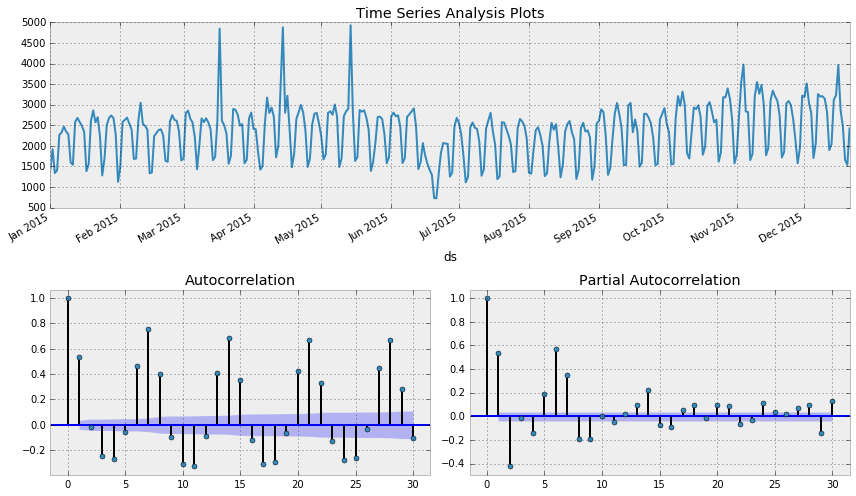

In [77]:
## ВАШ КОД для проверки стационарности ряда ##
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    
    return 

tsplot(train_df['y'], lags=30)

Критерий Дики-Фуллера: p=0.116981
Оптимальный параметр преобразования Бокса-Кокса: 0.732733


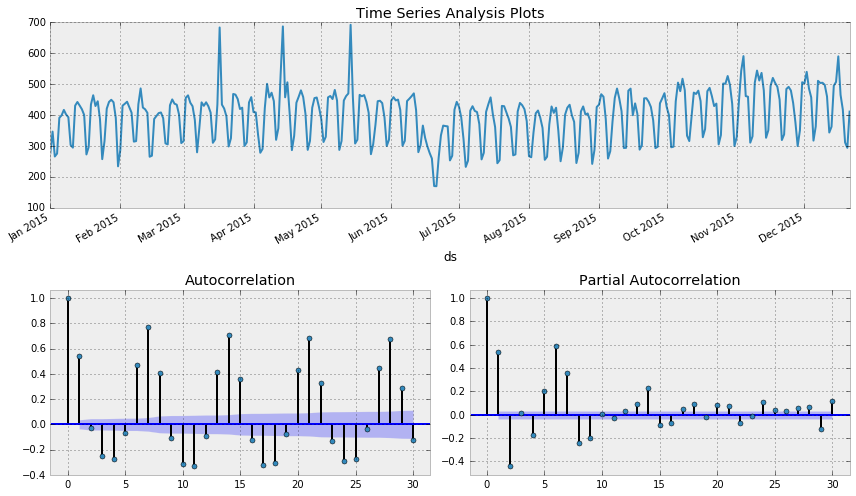

In [78]:
box_cox = train_df.copy()
box_cox['yb'], lmbda = scs.boxcox(box_cox['y'] + 1)

tsplot(box_cox['yb'], lags=30)
print ("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)

Критерий Дики-Фуллера: p=0.000000


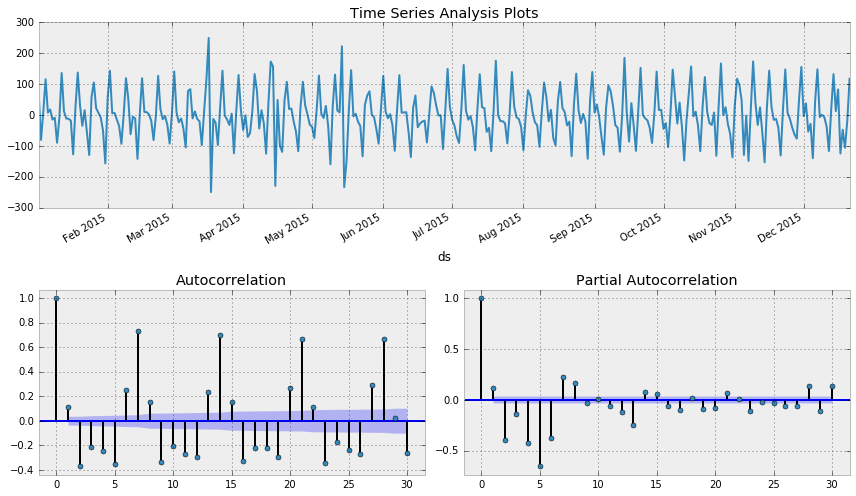

In [79]:
box_cox['weekly'] = box_cox['yb'] - box_cox['yb'].shift(1)
tsplot(box_cox['weekly'][1:], lags=30)

Критерий Дики-Фуллера: p=0.000000


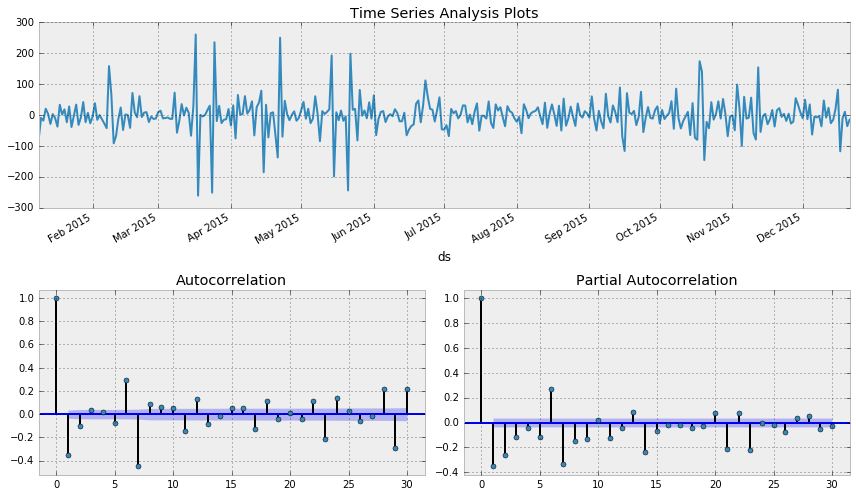

In [80]:
box_cox['weekly_shift'] = box_cox['weekly'] - box_cox['weekly'].shift(7)
tsplot(box_cox['weekly_shift'][8:], lags=30)

Критерий Дики-Фуллера: p=0.000000


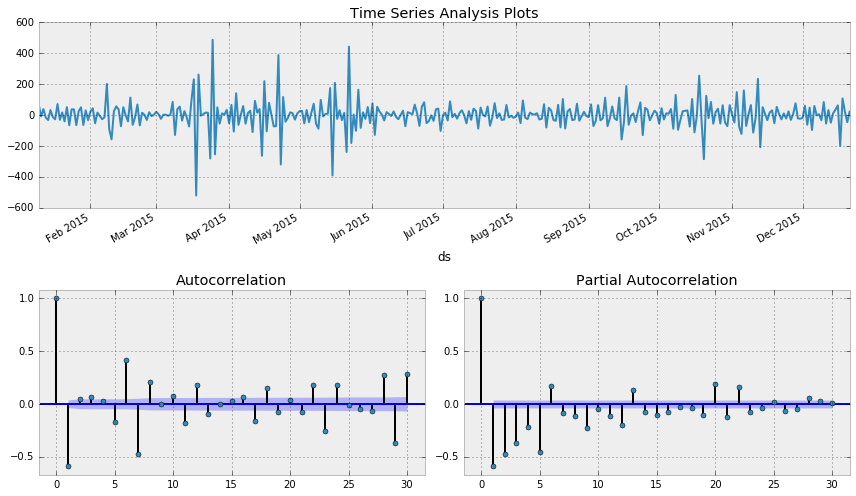

In [81]:
tsplot((box_cox['weekly_shift'] - box_cox['weekly_shift'].shift(1))[9:], lags=30)

**Вопрос 5**: Далее перейдем к построению модели SARIMAX (`sm.tsa.statespace.SARIMAX`). Модель c какими параметрами лучшая по `AIC`-критерию?

In [2]:
## ВАШ КОД для построения модели ##
p = 1
ds = [0, 1]
q = 2
P = 3
Ds = [1, 2]
Qs = [0, 1]

In [3]:
from itertools import product

parameters = product(ds, Ds, Qs)
parameters_list = list(parameters)
len(parameters_list)

8

In [4]:
%%time
results = []
best_aic = float("inf")

for param in parameters_list:
    print(param)
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(box_cox['yb'], order=(p, param[0], q), seasonal_order=(P, param[1], param[2], 7)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

(0, 1, 0)


NameError: name 'sm' is not defined

In [85]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

  parameters          aic
3  (0, 2, 1)  3528.000252
7  (1, 2, 1)  3533.891947
0  (0, 1, 0)  3556.216056
1  (0, 1, 1)  3556.339128
5  (1, 1, 1)  3557.293083


In [65]:
print(best_model.summary())

                                 Statespace Model Results                                
Dep. Variable:                                 y   No. Observations:                  353
Model:             SARIMAX(1, 0, 2)x(3, 2, 1, 7)   Log Likelihood               -2479.741
Date:                           Sun, 14 May 2017   AIC                           4975.482
Time:                                   00:10:09   BIC                           5006.414
Sample:                               01-01-2015   HQIC                          4987.790
                                    - 12-21-2015                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.035     28.491      0.000       0.931       1.069
ma.L1         -0.5098      2.736     -0.186

Критерий Дики-Фуллера: p=0.000000


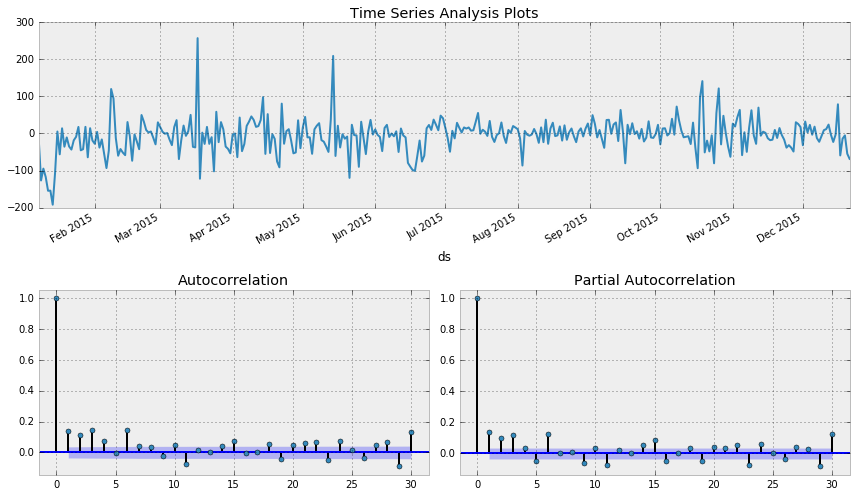

In [86]:
tsplot(best_model.resid[7:], lags=30)

In [89]:
box_cox["arima_model"] = best_model.fittedvalues
forecast = best_model.predict(start = box_cox.shape[0], end = (box_cox.shape[0] + 7))
forecast = box_cox.arima_model.append(forecast).values[-100:]

actual = data.Users.values[-100:]
plt.figure(figsize=(15, 7))
plt.plot(forecast, color='r', label="model")
plt.title("SARIMA model\n Mean absolute error {} users".format(round(mean_absolute_error(box_cox.dropna().y, box_cox.dropna().arima_model))))

plt.plot(actual, label="actual")
plt.legend()
plt.axvspan(len(actual), len(forecast), alpha=0.5, color='lightgrey')
plt.grid(True)

TypeError: unsupported operand type(s) for *: 'int' and 'NoneType'